In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.set_option('future.no_silent_downcasting', True)

In [16]:
# ==========================================
# 1. CARGA DE DATOS
# ==========================================
# ruta pablo
ruta = "data_adolescentes/adolescentes_ensanut2023_w_n.csv"
# ruta dani
# ruta = "/Users/danielarenee/Desktop/MD_proyecto_final/data_adolescentes/adolescentes_ensanut2023_w_n.csv"
data = pd.read_csv(ruta, delimiter=";")

In [17]:
# ==========================================
# 2. CREACIÓN DE VARIABLE TARGET
# ==========================================

variables_depresion = ['d0601a', 'd0601b', 'd0601c', 'd0601d', 'd0601f', 'd0601g']

data_copy = data.copy()

# Convertir a numérico
for var in variables_depresion:
    data_copy[var] = pd.to_numeric(data_copy[var].replace(' ', np.nan), errors='coerce')

# Invertir d0601f y crear score (rango: 6-23)
data_copy['d0601f_inv'] = 5 - data_copy['d0601f']
variables_score = ['d0601a', 'd0601b', 'd0601c', 'd0601d', 'd0601f_inv', 'd0601g']
data_copy['score_depresion'] = data_copy[variables_score].sum(axis=1)

# Clasificar en 4 categorías ordinales (≤6, 7-8, 9-11, ≥12)
def clasificar_depresion(score):
    if pd.isna(score):
        return np.nan
    elif score <= 6:
        return "Sin depresión"
    elif score <= 8:
        return "Leve"
    elif score <= 11:
        return "Moderada"
    else:
        return "Severa"

data_copy['nivel_depresion'] = data_copy['score_depresion'].apply(clasificar_depresion)

# Mostrar distribución
print("Distribución de clases:")
for nivel, n in data_copy['nivel_depresion'].value_counts().items():
    print(f"  {nivel:<15}: {n:>6} ({n/len(data_copy)*100:>5.1f}%)")

Distribución de clases:
  Sin depresión  :    714 ( 37.1%)
  Leve           :    501 ( 26.0%)
  Moderada       :    490 ( 25.5%)
  Severa         :    219 ( 11.4%)


In [18]:
# ==========================================
# 3. SELECCIÓN DE FEATURES
# ==========================================
# Total: 21 features
ft_demograficas = ['edad', 'sexo']
ft_alimentarias = ['d06a1', 'd06a2', 'd06a3', 'd06a4', 'd06a5', 'd06a6', 'd06a7', 'd06a8', 'd06a9', 'd06a10']

# d0701 - accidentes
# d0801 - agresión
# d0810 - abuso sexual
# d0817 - pensamientos suicidas
# d0819 - autolesiones
# d0101 - consumo de tabaco
# d0108 - consumo de alcohol
# d0421 - ansiedad
# d0601e - sueño

ft_extras = ['d0701', 'd0801', 'd0810', 'd0817', 'd0819', 'd0101', 'd0108', 'd0421', 'd0601e']

selected_features = ft_demograficas + ft_alimentarias + ft_extras


In [19]:
# ==========================================
# 4. PREPARACIÓN DE DATOS
# ==========================================
# Crear dataset con features + target
df_model = data_copy[selected_features + ['nivel_depresion']].copy()

# Convertir features a numérico
for col in selected_features:
    df_model[col] = pd.to_numeric(df_model[col].replace(' ', np.nan), errors='coerce')

# Eliminar filas sin target o con missing en features
df_clean = df_model.dropna()

print(f"Observaciones: {len(data_copy)} → {len(df_clean)} (perdidas: {len(data_copy)-len(df_clean)})")


Observaciones: 1924 → 1592 (perdidas: 332)


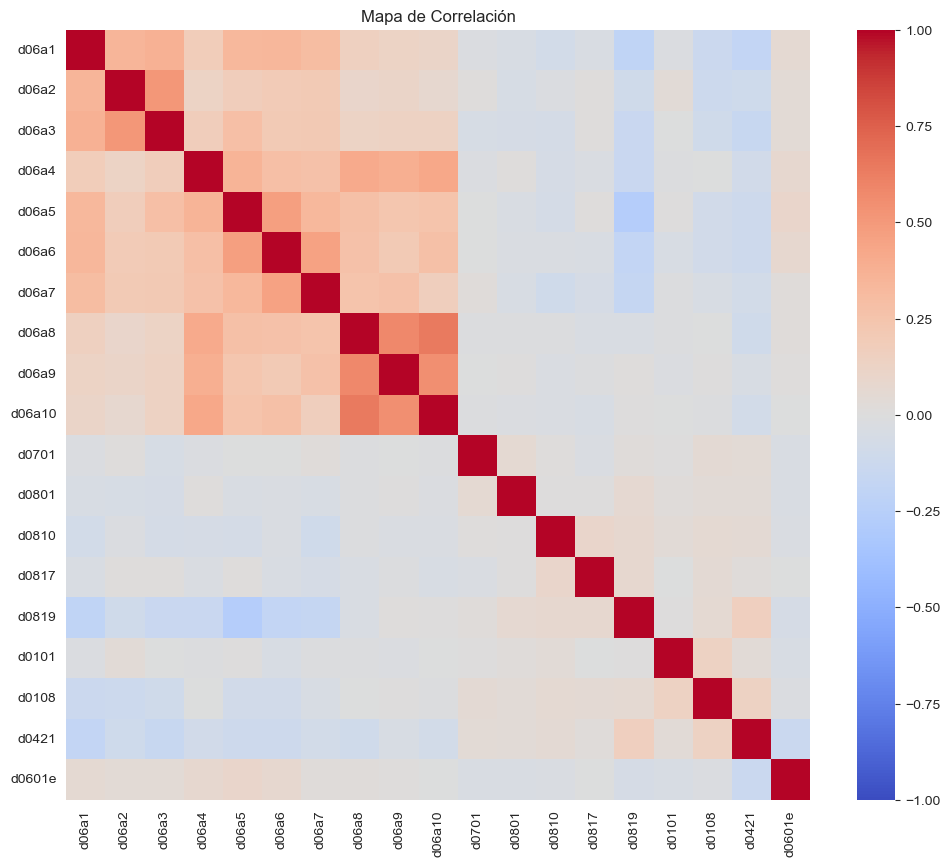

d06a8   d06a10    0.641805
d06a10  d06a8     0.641805
d06a8   d06a9     0.584085
d06a9   d06a8     0.584085
        d06a10    0.550175
d06a10  d06a9     0.550175
d06a3   d06a2     0.513320
d06a2   d06a3     0.513320
d06a5   d06a6     0.473803
d06a6   d06a5     0.473803
dtype: float64


In [20]:
# ==========================================
# 4. PREPARACIÓN DE DATOS // CORRELACIÓN Y PCA PREP.
# ==========================================

cols = ["edad", "sexo", "nivel_depresion"]
df_analisis = df_clean.drop(columns=cols)

plt.figure(figsize=(12, 10))
corr_matrix = df_analisis.corr()


sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Correlación")
plt.show()

corr = df_analisis.corr().abs()

top_corr = (
    corr.where(~np.eye(corr.shape[0], dtype=bool))
        .unstack()
        .dropna()
        .sort_values(ascending=False)
)

print(top_corr.head(10))


In [21]:
# ==========================================
# 5. INTENTO DE PCA (NO JUZGAR ESTUVO DIFICIL)
# ==========================================
cols_alimentacion = ft_alimentarias
X = df_analisis[cols_alimentacion]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
components = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_ * 100
cum_var = np.cumsum(explained_var)
eigenvalues = pca.explained_variance_

print(f"{'Comp':<5} | {'Eigenvalor':<10} | {'Varianza':<10} | {'Acumulado':<10}")
print("-" * 45)

for i in range(len(eigenvalues)):

    print(f"PC{i+1:<3} | {eigenvalues[i]:<10.4f} | {explained_var[i]:<10.2f} | {cum_var[i]:<10.2f}")

df_pca = pd.DataFrame(components, columns=[f'PC{i + 1}' for i in range(len(eigenvalues))])

Comp  | Eigenvalor | Varianza   | Acumulado 
---------------------------------------------
PC1   | 3.5338     | 35.32      | 35.32     
PC2   | 1.6973     | 16.96      | 52.28     
PC3   | 1.0598     | 10.59      | 62.87     
PC4   | 0.7242     | 7.24       | 70.11     
PC5   | 0.6441     | 6.44       | 76.54     
PC6   | 0.6056     | 6.05       | 82.60     
PC7   | 0.5265     | 5.26       | 87.86     
PC8   | 0.4670     | 4.67       | 92.53     
PC9   | 0.4091     | 4.09       | 96.61     
PC10  | 0.3388     | 3.39       | 100.00    


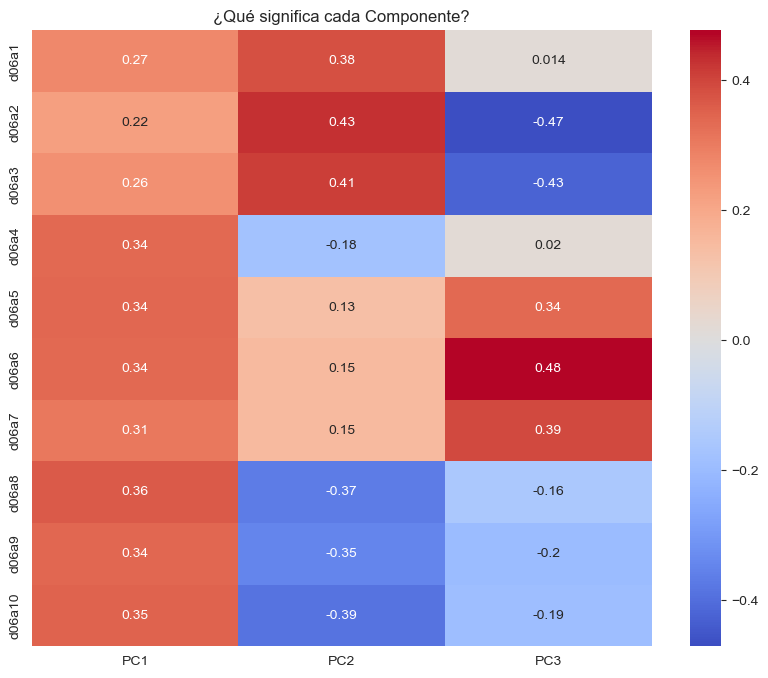

In [22]:
pca_weights = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(cols_alimentacion))],
    index=cols_alimentacion
)

final_weights = pca_weights.iloc[:, :3]

plt.figure(figsize=(10, 8))
sns.heatmap(final_weights, annot=True, cmap='coolwarm', center=0)
plt.title("¿Qué significa cada Componente?")
plt.show()

In [23]:

df_pca_final = df_pca.iloc[:, :3].copy()

# los nombres son por los que explican mas la grafica de arriba
# tipo: el PC1 salen todos positivos entonces explica como la severidad total de la
# conducta alimenticia, el PC2 explica "si has comido demasiado" y "has perdido el
# control sobre lo que comer" y si sale bajo es que usas quimicos
# el PC3 explica las dietas, ayunos y ejercicio pero si sale bajo tambien explica
# el descontrol y comer demasiado

df_pca_final.columns = ['severidad_total', 'atracon_purga', 'restriccion_descontrol']
# si se te ocurren mejores nombre para las columnas cambialos
df_modelado = pd.concat([df_analisis.reset_index(drop=True), df_pca_final], axis=1)
df_modelado = df_modelado.drop(columns=ft_alimentarias)

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ps222\AppData\Local\Temp\ipykernel_21512\1407443564.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Visualización de Encuesta en $\mathbb{R}^2$ (PCA)', fontsize=15)


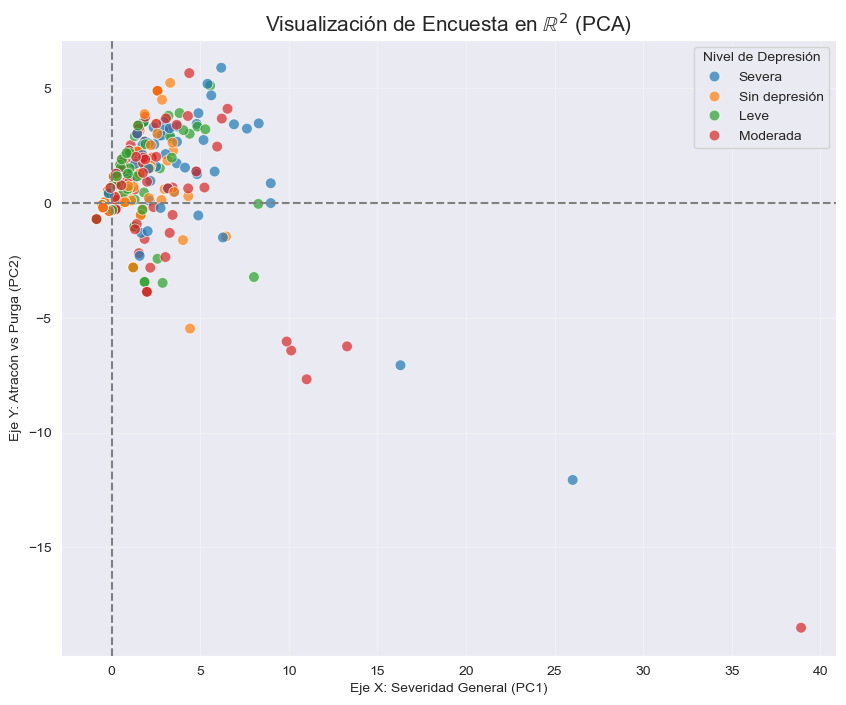

In [24]:
# ==========================================
# 6. VISUALIZACIÓN ?
# ==========================================

x = df_modelado['severidad_total']
y = df_modelado['atracon_purga']

categories = df_clean['nivel_depresion'].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, hue=categories, s=60, alpha=0.7)

plt.title('Visualización de Encuesta en $\mathbb{R}^2$ (PCA)', fontsize=15)
plt.xlabel('Eje X: Severidad General (PC1)')
plt.ylabel('Eje Y: Atracón vs Purga (PC2)')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.legend(title='Nivel de Depresión')
plt.grid(True, alpha=0.3)
plt.show()